In [1]:
from utils.bert import *
#import random

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

base_model_name = "all-mpnet-base-v2"  #"paraphrase-multilingual-mpnet-base-v2" 
import_path = "./Data/Preprocessed/data_with_filled_explanations_17.2.2022_no_duplicates_preprocessed.pickle"
new_model_name = "./Data/Bert/fine-tuned-bert-{}".format(datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
epochs_number = 3
batch_size = 40 # 30

In [ ]:
data = pd.read_pickle(import_path)
len(data)

In [4]:
data = pd.read_pickle(import_path)
train, dev_test = train_test_split(data, test_size = 0.2, random_state = 42)
dev, test = train_test_split(dev_test, test_size = 0.5, random_state = 42)

In [5]:
train = train[0:6000]

In [6]:
train = split_data(train, "explanation_prep")
dev = split_data(dev, "explanation_prep")
test = split_data(test, "explanation_prep")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1289 [00:00<?, ?it/s]

  0%|          | 0/1289 [00:00<?, ?it/s]

  0%|          | 0/1290 [00:00<?, ?it/s]

  0%|          | 0/1290 [00:00<?, ?it/s]

In [7]:
len(train)

206138

In [8]:
# Prepare triplets
triplets = get_triple_from_df(train, 'source_text_sentences_index',
                       "id" , "source_text_sentences","statement_prep")

  0%|          | 0/6000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [9]:
# Load pre-trained model - we are using the original Sentence-BERT for this example.
sbert_model = SentenceTransformer(base_model_name, device='cuda:0') # device='cuda:0'

# Initialize triplet loss
loss = TripletLoss(model = sbert_model)

In [10]:
finetune_data = SentencesDataset(examples=triplets, model=sbert_model)
finetune_dataloader = DataLoader(finetune_data, shuffle = True, batch_size = batch_size)

In [11]:
finetune_dataloader

In [12]:
triplets_dev = get_triple_from_df(dev, 'source_text_sentences_index',
                       "id" , "source_text_sentences","statement_prep")
evaluator = TripletEvaluator.from_input_examples(triplets_dev, name = 'dev')

  0%|          | 0/1289 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [13]:
triplets_test = get_triple_from_df(test, 'source_text_sentences_index',
                       "id" , "source_text_sentences","statement_prep")

  0%|          | 0/1290 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [14]:
####  Configure the fine-tunning #### 
warmup_steps = math.ceil(len(finetune_data) * epochs_number / batch_size * 0.1) # 10% of train data for warm-up
print("Warmup-steps: {}".format(warmup_steps))

# Fine-tune the model
start = time.time()
gc.collect()
torch.cuda.empty_cache()
sbert_model.fit(train_objectives=[(finetune_dataloader, loss)],
                evaluator = evaluator,
                epochs = epochs_number,
                evaluation_steps = 0,
                warmup_steps = warmup_steps,
                output_path = new_model_name,
                checkpoint_path = new_model_name + "/checkpoints/"
               ) #epochs_number
end = time.time()
print("Time for fine-tunning took "+ str((end - start)/60)+" minutes") 

Warmup-steps: 1547


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5154 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5154 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5154 [00:00<?, ?it/s]

Time for fine-tunning took 54.34315858681997 minutes


In [20]:
params = {'main_distance_function': 0, 'show_progress_bar': True}
test_evaluator = TripletEvaluator.from_input_examples(triplets_test, name = 'test', **params)
test_evaluator(sbert_model, output_path = new_model_name)

Batches:   0%|          | 0/2772 [00:00<?, ?it/s]

Batches:   0%|          | 0/2772 [00:00<?, ?it/s]

Batches:   0%|          | 0/2772 [00:00<?, ?it/s]

0.8430691506157246

In [21]:
#### Visuzlize the performance of training model on STS benchmark train, dev, test dataset ####
train_dev_result = pd.read_csv(new_model_name + '/eval/triplet_evaluation_dev_results.csv').iloc[-2:,:]
test_result = pd.read_csv(new_model_name + '/triplet_evaluation_test_results.csv')

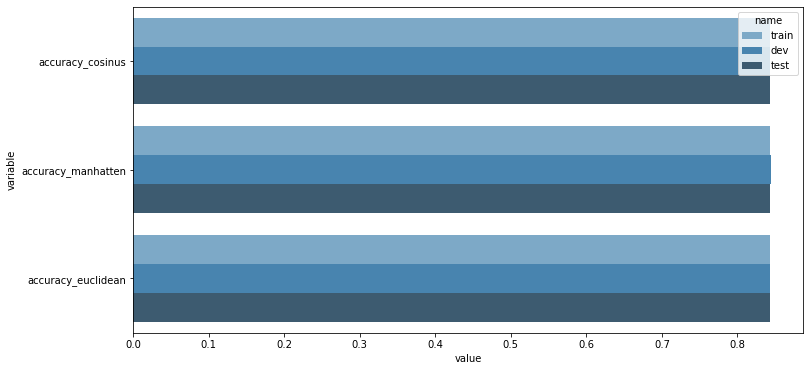

In [22]:
result = pd.concat([train_dev_result, test_result]).iloc[:,2:]
result['name'] = ["train", "dev", "test"]
plot_result = pd.melt(result, id_vars=['name'])

plt.figure(figsize = (12,6))
sns.barplot(x="value", y="variable", hue="name", data=plot_result, palette="Blues_d");